# FORS1 longslit observations of NGC 343

These are spectra that are described in [Valerdi et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...876...98V). 

What I want to do here is analyze the spectra at their full angular resolution, rather than binned in 10-arcsecond windows, as was done in that paper.  This is necessary for investigating the spectrum of W 3's bow shock.

Slit A crosses W 3 (near enough) and is close to the axis of the bow shock.  It shows the compact He II 4686 emission from the inner rim. 

Slit B is parallel to A, displaced 8 arcsec to south.  It just misses the inner rim, but does show the enhanced [Ar IV] zone of the bow shock. 

I would like to achieve the following:

1. [X] Identify W 3 and the bow shock in the spectra
2. [ ] Trace the full western extent of the bow shock in [Ar IV]
    - the MUSE field extends only 22 arcsec from the star 
    - the FORS1 spectrum shows a roughly linear ramp that extends about 34 arcsec (see image below)
3. [ ] Calculate the [O III] 4363/5007 temperature profile of the bow shock
    - See if there is any evidence for temperatures as high as the [Ar IV] temperature
4. [ ] Measure the [Ne III] 3869 profile.  Ne$^+$ has the same ionization potential as Ar$^{+2}$ (40 eV), but [Ne III] seems to be much more broadly distributed than [Ar IV] 



![FORS1 profile of Ar IV](assets/ngc346-screenshot-fors1-ariv-profile.png)


In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import regions
from astropy.io import fits
from astropy.wcs import WCS
import sys
sys.path.append("../lib")
import extract

sns.set_context("talk")
sns.set_color_codes()

MPDAF does not seem to have good functionality for dealing with position–velocity images, so we will just use basic astropy functionality.

In [2]:
hdulist = fits.open("../data/30050000.346A.04.1.B.W.fits")
hdulist.info()

Filename: ../data/30050000.346A.04.1.B.W.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   (2048, 2048)   float32   


In [3]:
slitA = hdulist[0]
w = WCS(slitA.header, fix=False)
w

 [astropy.io.fits.verify]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/astropy/wcs/wcs.py:2855: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


WCS Keywords

Number of WCS axes: 2
CTYPE : 'LINEAR'  'LINEAR'  
CRVAL : 3561.03466796875  1.0  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 0.0  -1.0  
PC2_1 PC2_2  : 1.0  0.0  
CDELT : 1.17881751060486  1.0  
NAXIS : 2048  2048

That PC matrix is not right, so I switch it back to the identity matrix:

In [4]:
w.wcs.pc = np.eye(2)

While we are here, we can give names and units to the axes.  And change the spatial axis from pixels to arcsec.  Also, put the spatial origin at the position of the star W3.

In [5]:
w.wcs.cname = "wavelength", "position"
w.wcs.cunit = "Angstrom", "arcsec"
w.wcs.cdelt[1] = 0.2
w.wcs.cd[1, 1] = 0.2
w.wcs.crpix[1] = 900.0
w.wcs.crval[1] = 0.0
w.wcs

<ipython-input-5-a9301d1c755d>:3: RuntimeWarning: cdelt will be ignored since cd is present
  w.wcs.cdelt[1] = 0.2


       flag: 137
      naxis: 2
      crpix: 0x7fdd203dc8e0
               1.0000       900.00    
         pc: 0x7fdd203dc8f0
    pc[0][]:   1.0000       0.0000    
    pc[1][]:   0.0000       1.0000    
      cdelt: 0x7fdd203c3070
               1.1788       0.20000   
      crval: 0x7fdd203c3080
               3561.0       0.0000    
      cunit: 0x7fdd203df500
             "Angstrom"
             "arcsec"
      ctype: 0x7fdd2038fc00
             "LINEAR"
             "LINEAR"
    lonpole: UNDEFINED
    latpole: 90.000000
    restfrq: 0.000000
    restwav: 0.000000
        npv: 0
     npvmax: 0
         pv: 0x0
        nps: 0
     npsmax: 0
         ps: 0x0
         cd: 0x7fdd203c3090
    cd[0][]:   1.1788       0.0000    
    cd[1][]:   0.0000       0.20000   
      crota: 0x7fdd2038fc90
              -90.000       0.0000    
     altlin: 7
     velref: 0
        alt: ' '
     colnum: 0
      colax: 0x7fdd203ad0e0
                 0      0
      cname: 0x7fdd203ba560
             "

Plot the full spectrum at different brightness levels:

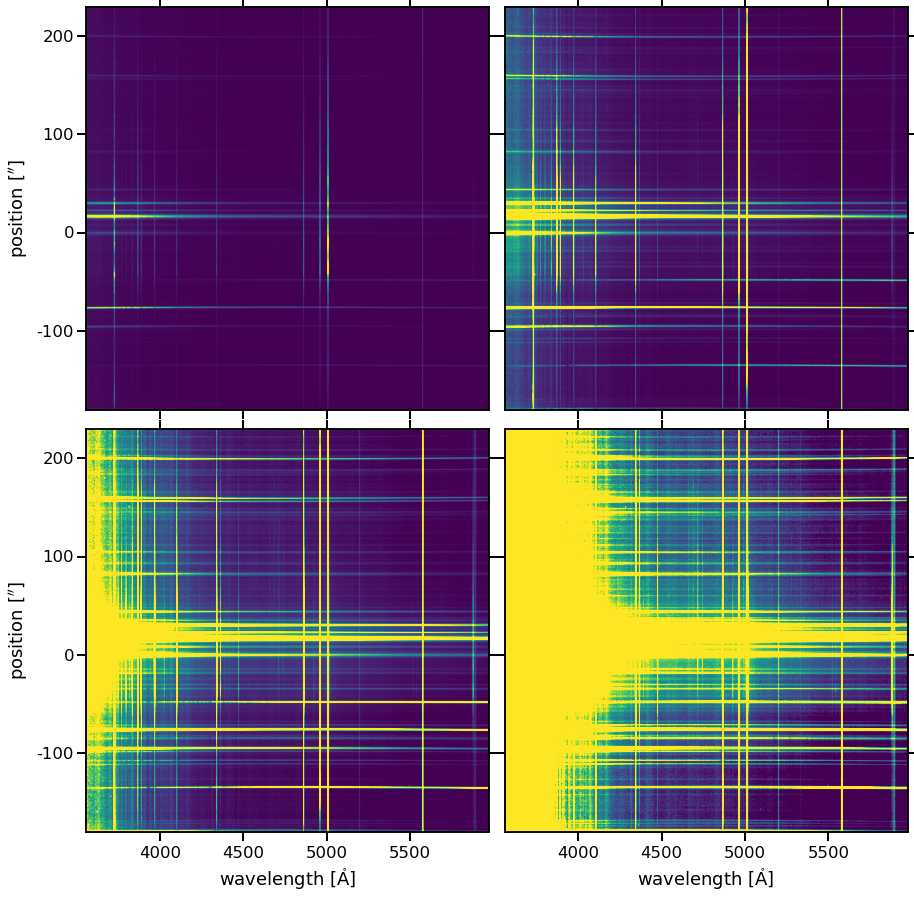

In [6]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(12, 12),
    subplot_kw=dict(projection=w),
    sharex=True,
    sharey=True,
)
for ax, vmax in zip(axes.flat, [3000, 300, 100, 30]):
    ax.imshow(slitA.data, origin="lower", vmin=10, vmax=vmax)
for ax in axes[:, 1]:
    ax.coords[1].set_ticklabel_visible(False)
    ax.coords[1].set_axislabel(" ")
for ax in axes[0, :]:
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[0].set_axislabel(" ")
fig.tight_layout();

Make a function that extracts a rectangular sub-image, specified in world coordinates.  It also returns the corresponding WCS for use in plotting:

In [7]:
def pvslice(im, w, wavrange, posrange):
    """
    Return the (image, wcs) tuple of a sub-image of the PV image `im`
    with WCS `w` for the wavelength range `wavrange` and the position range `posrange`
    
    """
    xlim, ylim = w.world_to_pixel_values(wavrange, posrange)
    # Force pixel limits to be in bounds
    ny, nx = im.shape
    ylim[0] = max(0, ylim[0])
    ylim[1] = min(ny - 1, ylim[1])
    xlim[0] = max(0, xlim[0])
    xlim[1] = min(nx - 1, xlim[1])
    
    xslice, yslice = slice(*xlim.astype(int)), slice(*ylim.astype(int))
    return im[yslice, xslice], w.slice((yslice, xslice))

Test it out by plotting the He II and [Ar IV] lines from bow shock

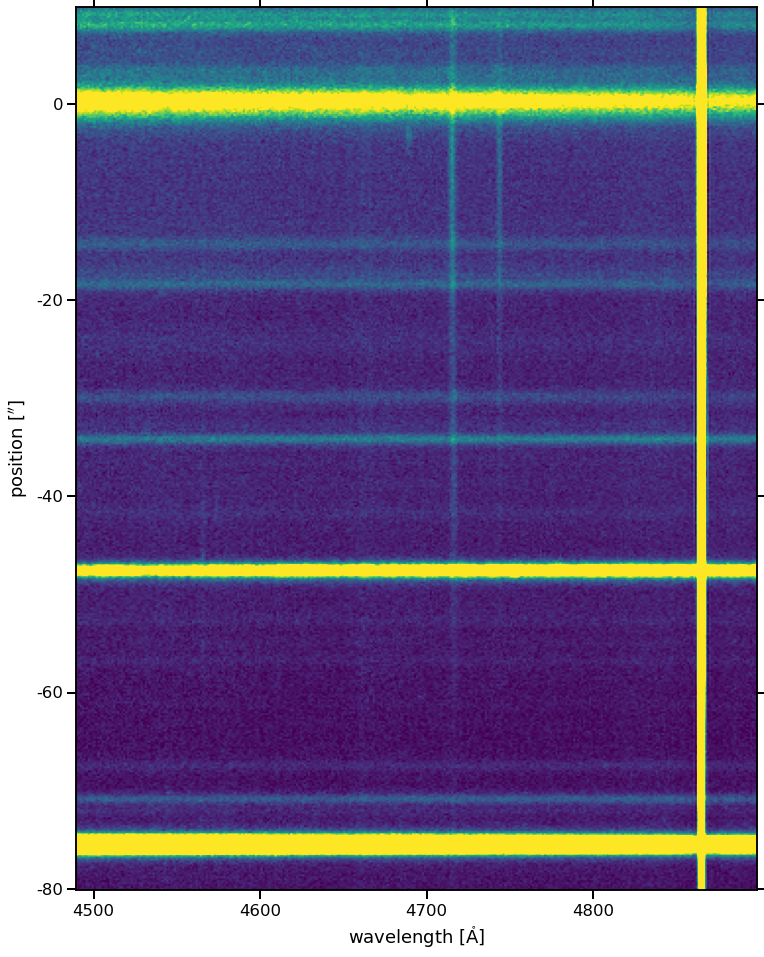

In [8]:
im, ww = pvslice(slitA.data, w, [4490, 4900], [-80, 10])
fig, ax = plt.subplots(
    figsize=(10, 15),
    subplot_kw=dict(projection=ww),
)
ax.imshow(im, origin="lower", vmin=10, vmax=100)
fig.tight_layout();

We can also use it for plotting a 1D spectrum

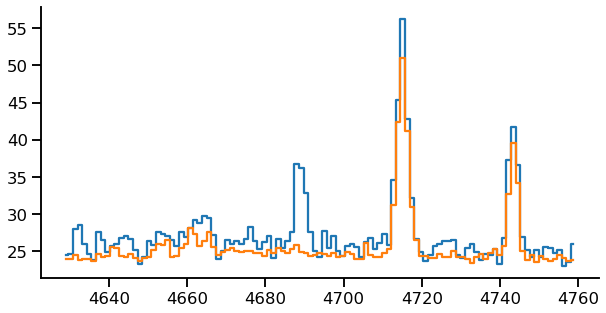

In [9]:
fig, ax = plt.subplots(
    figsize=(10, 5),
)

wav1, wav2 = 4630, 4760
im, ww = pvslice(slitA.data, w, [wav1, wav2], [-5, -3])
spec = im.mean(axis=0)
n = len(spec)
wavs, _ = ww.pixel_to_world_values(np.arange(n), [0]*n)
ax.plot(wavs, spec, drawstyle="steps-mid")

im, ww = pvslice(slitA.data, w, [wav1, wav2], [-15, -5])
spec2 = im.mean(axis=0)
ax.plot(wavs, spec2, drawstyle="steps-mid")

ax.set(
#    ylim=[20, 60],
)
sns.despine();

And for plotting profile cuts

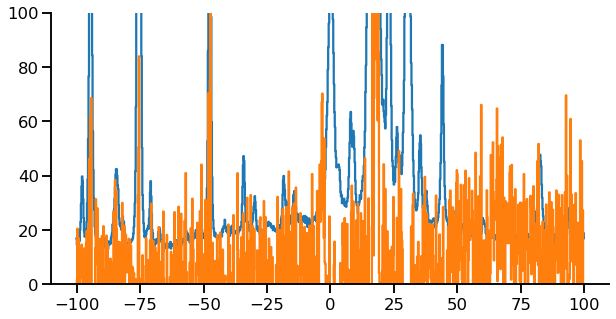

In [10]:
fig, ax = plt.subplots(
    figsize=(10, 5),
)
smin, smax = -100, 100

# Continua
im, ww = pvslice(slitA.data, w, [4670, 4680], [smin, smax])
cont01 = im.mean(axis=1, keepdims=True)
n, _ = cont01.shape
_, positions = ww.pixel_to_world_values([0]*n, np.arange(n))

im, ww = pvslice(slitA.data, w, [4695, 4710], [smin, smax])
cont02 = im.mean(axis=1, keepdims=True)

im, ww = pvslice(slitA.data, w, [4728, 4739], [smin, smax])
cont03 = im.mean(axis=1, keepdims=True)

im, ww = pvslice(slitA.data, w, [4750, 4760], [smin, smax])
cont04 = im.mean(axis=1, keepdims=True)

# Lines
im, ww = pvslice(slitA.data, w, [4682, 4698], [smin, smax])
i4686 = (im - 0.5*(cont01 + cont02)).sum(axis=1)

c4686 = (0.5*(cont01 + cont02)).sum(axis=1)





ax.plot(positions, c4686, drawstyle="steps-mid")
ax.plot(positions, i4686, drawstyle="steps-mid")

ax.set(
    #yscale="log",
    ylim=[0, 100],
)
sns.despine();

## Fit and remove continuum 

First I will deal with the region around He II and [Ar IV] line.  Plot a wider range than before and work out some good ranges for the continuum.  

Start with the less blue side of the full spectrum, since the continuum seems to change slope below 4500 Å and it would probably be better to fit range that separately. 

We can start off by trying the ranges that we used in 03-04-blue-lines-sharp-extract.py, but we can extend the continuum ranges because we have a wider wavelength range here. 



In [11]:
wavranges = [
    (4490, 4530),
    (4550, 4640), (4720, 4730), (4760, 4800), (4880, 4915),
    (4937, 4947), (4974, 4984), (5028, 5038), (5070, 5100), 
    (5120, 5145), (5220, 5260), (5330, 5390), (5450, 5510),
    (5700, 5850), (5950, 5980),
]


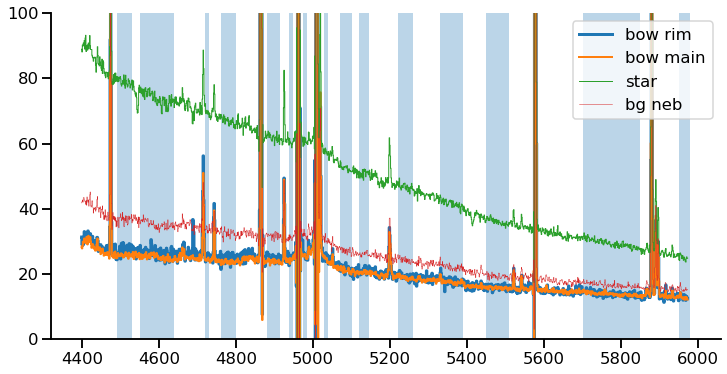

In [12]:
fig, ax = plt.subplots(
    figsize=(12, 6),
)

wav1, wav2 = 4400, 6000
im, ww = pvslice(slitA.data, w, [wav1, wav2], [-5, -3])
spec = im.mean(axis=0)
n = len(spec)
wavs, _ = ww.pixel_to_world_values(np.arange(n), [0]*n)
ax.plot(wavs, spec, drawstyle="steps-mid", linewidth=3, label="bow rim")

im, ww = pvslice(slitA.data, w, [wav1, wav2], [-15, -5])
spec2 = im.mean(axis=0)
ax.plot(wavs, spec2, drawstyle="steps-mid", linewidth=2, label="bow main")

im, ww = pvslice(slitA.data, w, [wav1, wav2], [-3, 3])
spec3 = im.mean(axis=0)
ax.plot(wavs, spec3, drawstyle="steps-mid", linewidth=1, label="star")

im, ww = pvslice(slitA.data, w, [wav1, wav2], [4, 8])
spec4 = im.mean(axis=0)
ax.plot(wavs, spec4, drawstyle="steps-mid", linewidth=0.5, label="bg neb")

for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.legend()
ax.set(
    ylim=[0, 100],
)
sns.despine();

Try using a 4th order polynomial:

In [13]:
im, ww = pvslice(slitA.data, w, [wav1, wav2], [-200, 300])
imc = extract.pv_fit_continuum(
    im, ww, wav_ranges=wavranges, deg=4, median=False,
)

extract.pv_fit_continuum: row 0
extract.pv_fit_continuum: row 10
extract.pv_fit_continuum: row 20
extract.pv_fit_continuum: row 30
extract.pv_fit_continuum: row 40
extract.pv_fit_continuum: row 50
extract.pv_fit_continuum: row 60
extract.pv_fit_continuum: row 70
extract.pv_fit_continuum: row 80
extract.pv_fit_continuum: row 90
extract.pv_fit_continuum: row 100
extract.pv_fit_continuum: row 110
extract.pv_fit_continuum: row 120
extract.pv_fit_continuum: row 130
extract.pv_fit_continuum: row 140
extract.pv_fit_continuum: row 150
extract.pv_fit_continuum: row 160
extract.pv_fit_continuum: row 170
extract.pv_fit_continuum: row 180
extract.pv_fit_continuum: row 190
extract.pv_fit_continuum: row 200
extract.pv_fit_continuum: row 210
extract.pv_fit_continuum: row 220
extract.pv_fit_continuum: row 230
extract.pv_fit_continuum: row 240
extract.pv_fit_continuum: row 250
extract.pv_fit_continuum: row 260
extract.pv_fit_continuum: row 270
extract.pv_fit_continuum: row 280
extract.pv_fit_continuum:

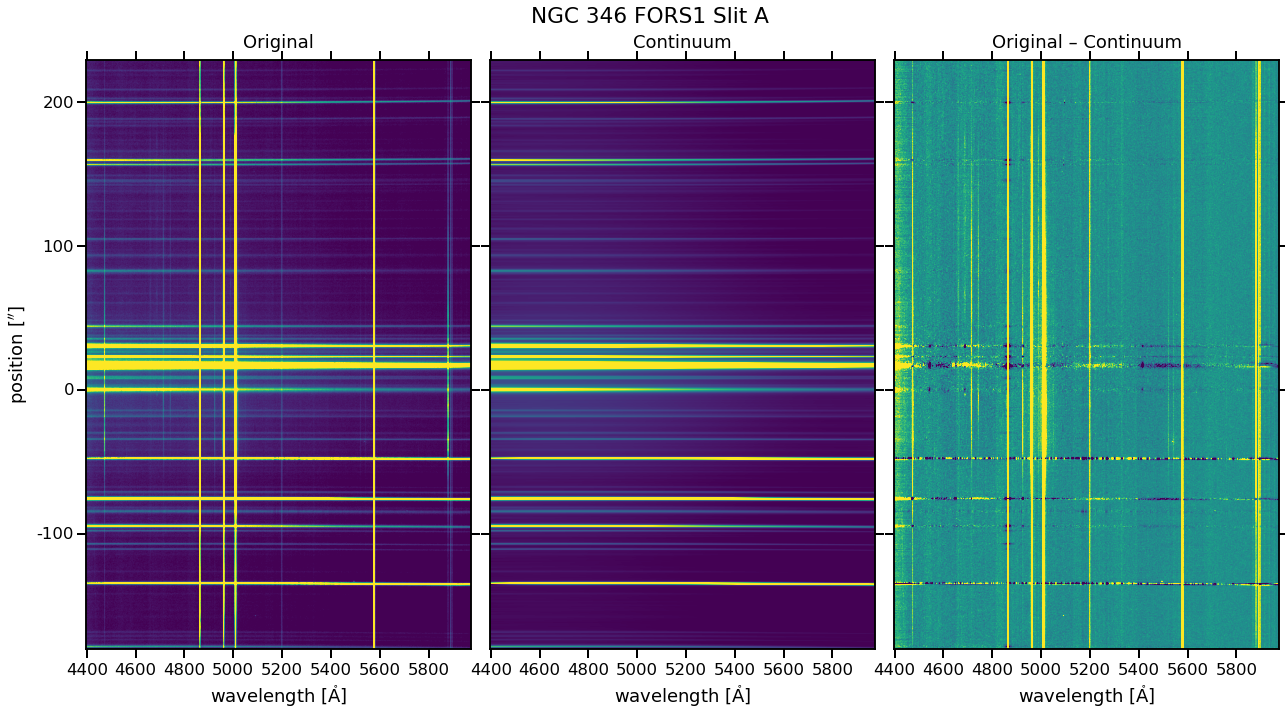

In [14]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 10),
    subplot_kw=dict(projection=ww),
    sharey=True,
)
axes[0].imshow(im, origin="lower", vmin=10, vmax=100)
axes[1].imshow(imc, origin="lower", vmin=10, vmax=100)
axes[2].imshow(im - imc, origin="lower", vmin=-10, vmax=10)
for ax in axes[1:]:
    ax.coords[1].set_ticklabel_visible(False)
    ax.coords[1].set_axislabel(" ")

axes[0].set_title("Original", pad=12)
axes[1].set_title("Continuum", pad=12)
axes[2].set_title("Original – Continuum", pad=12)
fig.suptitle("NGC 346 FORS1 Slit A")
fig.tight_layout(rect=(0.05, 0.05, 1.0, 1.0))
fig.savefig(f"../figs/ngc346-fors1-A-continuum-subtraction-{wav1:d}-{wav2:d}.pdf");

That looks pretty good.  There is a bit of noise for λ < 4490 Å, but that is of course expected since it is outside of the `wavranges` continuum intervals.

Save all 3 images in FITS format:

In [15]:
prefix = f"../data/ngc346-fors1-A-{wav1:d}-{wav2:d}"
hdr = ww.to_header()
fits.PrimaryHDU(header=hdr, data=im).writeto(
    f"{prefix}.fits",
    overwrite=True,
)
fits.PrimaryHDU(header=hdr, data=imc).writeto(
    f"{prefix}-cont.fits",
    overwrite=True,
)
fits.PrimaryHDU(header=hdr, data=im - imc).writeto(
    f"{prefix}-contsub.fits",
    overwrite=True,
)

Now do the same for the bluest range:

In [16]:
wavranges = [
    (3650, 3690),
    (3780, 3795),
    (3845, 3865),
    (3905, 3930), (3940, 3960),
    (3985, 4005), (4035, 4055), (4120, 4140),
    (4175, 4195), (4210, 4230), (4250, 4330),
    (4445, 4465), (4490, 4530),
    (4550, 4640), 
]

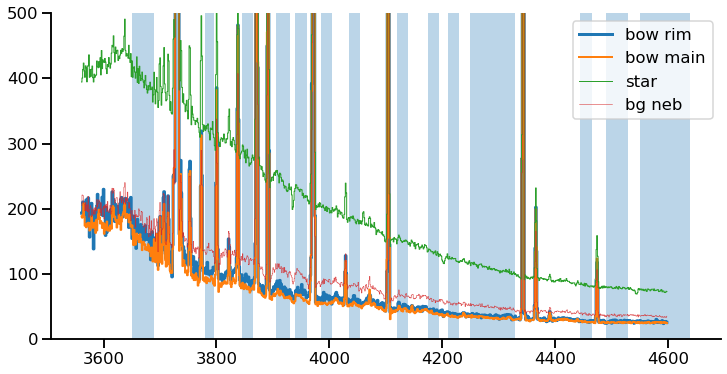

In [17]:
fig, ax = plt.subplots(
    figsize=(12, 6),
)

wav1, wav2 = 3500, 4600
im, ww = pvslice(slitA.data, w, [wav1, wav2], [-5, -3])
spec = im.mean(axis=0)
n = len(spec)
wavs, _ = ww.pixel_to_world_values(np.arange(n), [0]*n)
ax.plot(wavs, spec, drawstyle="steps-mid", linewidth=3, label="bow rim")

im, ww = pvslice(slitA.data, w, [wav1, wav2], [-15, -5])
spec2 = im.mean(axis=0)
ax.plot(wavs, spec2, drawstyle="steps-mid", linewidth=2, label="bow main")

im, ww = pvslice(slitA.data, w, [wav1, wav2], [-3, 3])
spec3 = im.mean(axis=0)
ax.plot(wavs, spec3, drawstyle="steps-mid", linewidth=1, label="star")

im, ww = pvslice(slitA.data, w, [wav1, wav2], [4, 8])
spec4 = im.mean(axis=0)
ax.plot(wavs, spec4, drawstyle="steps-mid", linewidth=0.5, label="bg neb")

for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.legend()
ax.set(
    ylim=[0, 500],
)
sns.despine();

In [18]:
im, ww = pvslice(slitA.data, w, [wav1, wav2], [-200, 300])
imc = extract.pv_fit_continuum(
    im, ww, wav_ranges=wavranges, deg=4, median=False,
)

extract.pv_fit_continuum: row 0
extract.pv_fit_continuum: row 10
extract.pv_fit_continuum: row 20
extract.pv_fit_continuum: row 30
extract.pv_fit_continuum: row 40
extract.pv_fit_continuum: row 50
extract.pv_fit_continuum: row 60
extract.pv_fit_continuum: row 70
extract.pv_fit_continuum: row 80
extract.pv_fit_continuum: row 90
extract.pv_fit_continuum: row 100
extract.pv_fit_continuum: row 110
extract.pv_fit_continuum: row 120
extract.pv_fit_continuum: row 130
extract.pv_fit_continuum: row 140
extract.pv_fit_continuum: row 150
extract.pv_fit_continuum: row 160
extract.pv_fit_continuum: row 170
extract.pv_fit_continuum: row 180
extract.pv_fit_continuum: row 190
extract.pv_fit_continuum: row 200
extract.pv_fit_continuum: row 210
extract.pv_fit_continuum: row 220
extract.pv_fit_continuum: row 230
extract.pv_fit_continuum: row 240
extract.pv_fit_continuum: row 250
extract.pv_fit_continuum: row 260
extract.pv_fit_continuum: row 270
extract.pv_fit_continuum: row 280
extract.pv_fit_continuum:

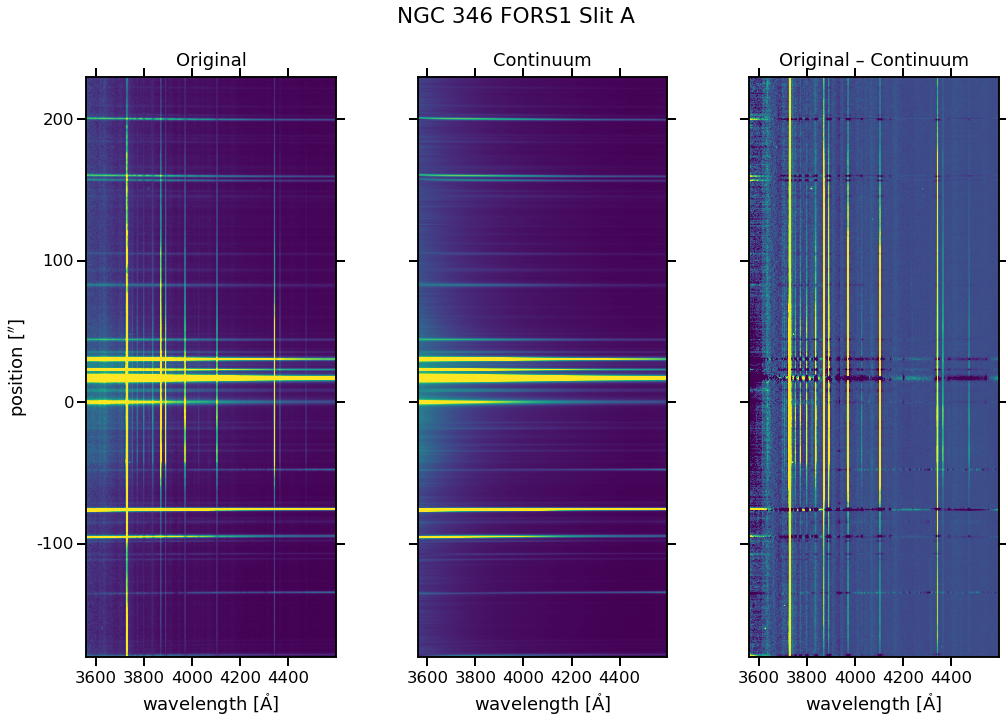

In [19]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(15, 10),
    subplot_kw=dict(projection=ww),
    sharey=True,
)
axes[0].imshow(im, origin="lower", vmin=10, vmax=500)
axes[1].imshow(imc, origin="lower", vmin=10, vmax=500)
axes[2].imshow(im - imc, origin="lower", vmin=-30, vmax=100)
for ax in axes[1:]:
    ax.coords[1].set_ticklabel_visible(False)
    ax.coords[1].set_axislabel(" ")

axes[0].set_title("Original", pad=12)
axes[1].set_title("Continuum", pad=12)
axes[2].set_title("Original – Continuum", pad=12)
fig.suptitle("NGC 346 FORS1 Slit A")
fig.tight_layout(rect=(0.05, 0.05, 1.0, 1.0))
fig.savefig(f"../figs/ngc346-fors1-A-continuum-subtraction-{wav1:d}-{wav2:d}.pdf");

In [20]:
prefix = f"../data/ngc346-fors1-A-{wav1:d}-{wav2:d}"
hdr = ww.to_header()
fits.PrimaryHDU(header=hdr, data=im).writeto(
    f"{prefix}.fits",
    overwrite=True,
)
fits.PrimaryHDU(header=hdr, data=imc).writeto(
    f"{prefix}-cont.fits",
    overwrite=True,
)
fits.PrimaryHDU(header=hdr, data=im - imc).writeto(
    f"{prefix}-contsub.fits",
    overwrite=True,
)